In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os

# Extended professional palette
colors = {
    'Greedy_Worst': '#E6194B',     # Red
    'Edf': '#FF7F00',       # Orange
    'Greedy_Green': '#3CB44B',     # Green
    'MILP': '#4363D8',      # Blue
    'RR': '#911EB4',        # Purple
    'Sjf': '#FFD700',       # Gold
}

mode = ''
schedules_path = f'schedules/{mode}'
graphs_output = f'graphs/{mode}'
schedules = {
    'Edf': pd.read_csv(f'{schedules_path}edf_schedule.csv'),
    'Greedy_Worst': pd.read_csv(f'{schedules_path}carbon_aware_max_case.csv'),
    'Greedy_Green': pd.read_csv(f'{schedules_path}carbon_aware_min_case.csv'),
    'MILP': pd.read_csv(f'{schedules_path}milp_green.csv'),
    'RR': pd.read_csv(f'{schedules_path}round_robin_schedule.csv'),
    'Sjf': pd.read_csv(f'{schedules_path}sjf_schedule.csv'),
}

associations_df = pd.read_csv('data/associations_df.csv')


In [ ]:
forecasts_df = pd.read_csv('data/forecast_data.csv')


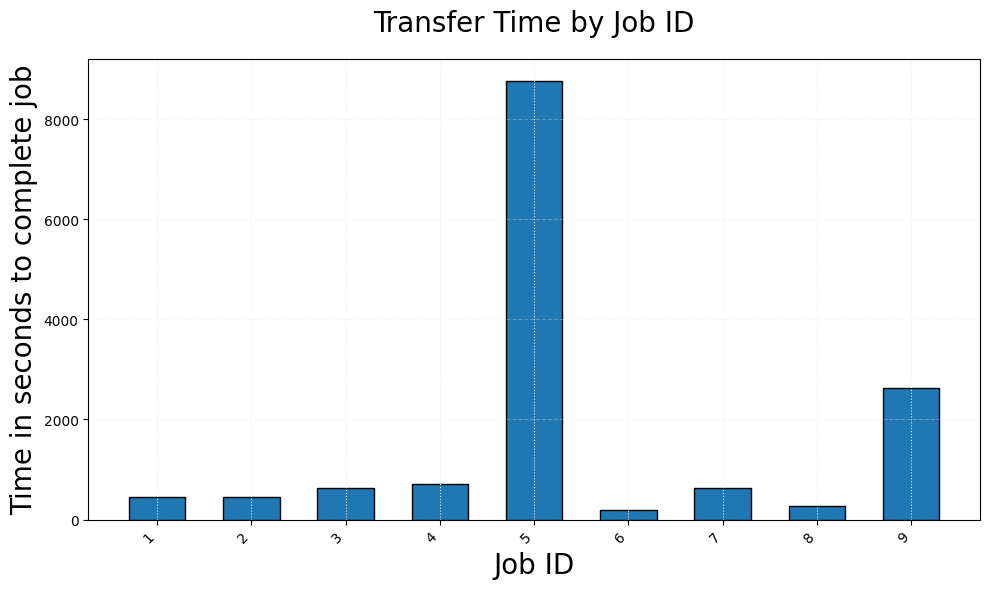

In [109]:
import json
filtered_df = associations_df[associations_df['forecast_id'] == 1]
plt.figure(figsize=(10,6))
plt.bar(filtered_df['job_id'], filtered_df['transfer_time'], color='#1f77b4', edgecolor="black", width=0.6)
plt.xlabel("Job ID", fontsize=20)
plt.ylabel("Time in seconds to complete job", fontsize=20)
plt.title('Transfer Time by Job ID', fontsize=20, pad=20)

plt.xticks(filtered_df['job_id'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

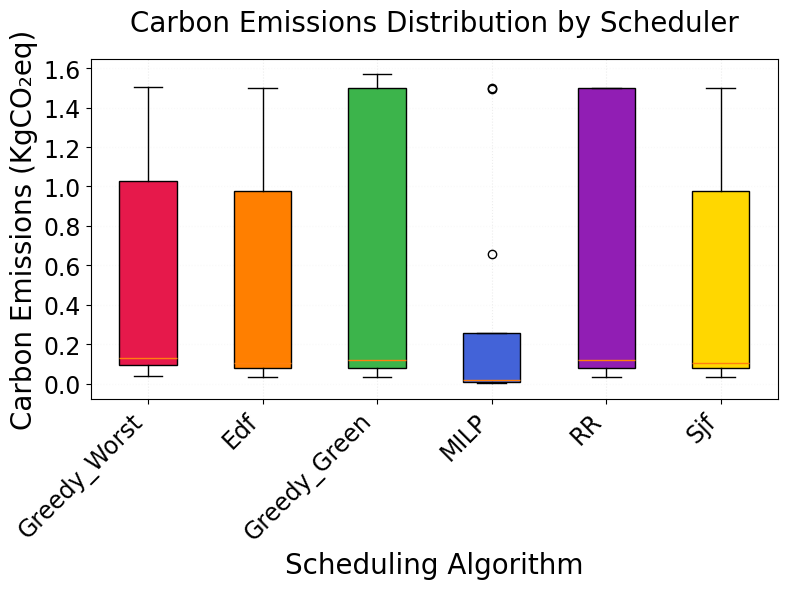

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 2. Prepare Plot Data
# ==================================================
data = []
labels = []
for planner in colors.keys():
    if planner in schedules:
        data.append(schedules[planner]['carbon_emissions']/1000)
        labels.append(planner)

# 3. Create Basic Boxplot
# ==================================================
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Create boxplot
boxplot = ax.boxplot(
    data,
    labels=labels,
    patch_artist=True,  # Enable color filling
    showfliers=True
)

# Apply colors
for patch, color in zip(boxplot['boxes'], colors.values()):
    patch.set_facecolor(color)


# Formatting
ax.set_xlabel('Scheduling Algorithm', fontsize=20)
ax.set_ylabel('Carbon Emissions (KgCO₂eq)', fontsize=20)
ax.set_title('Carbon Emissions Distribution by Scheduler', fontsize=20, pad=20)
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right', fontsize=17)
plt.yticks(fontsize=17)

# 4. Save and Show
# ==================================================
plt.tight_layout()
plt.savefig(f'{graphs_output}boxplot_algos.pdf',format='pdf', dpi=800, bbox_inches='tight')
plt.show()

Edf      total emissions: 5,516.02 gCO2
Greedy_Worst total emissions: 5,761.30 gCO2
Greedy_Green total emissions: 8,618.31 gCO2
MILP     total emissions: 4,073.57 gCO2
RR       total emissions: 7,466.91 gCO2
Sjf      total emissions: 5,516.02 gCO2


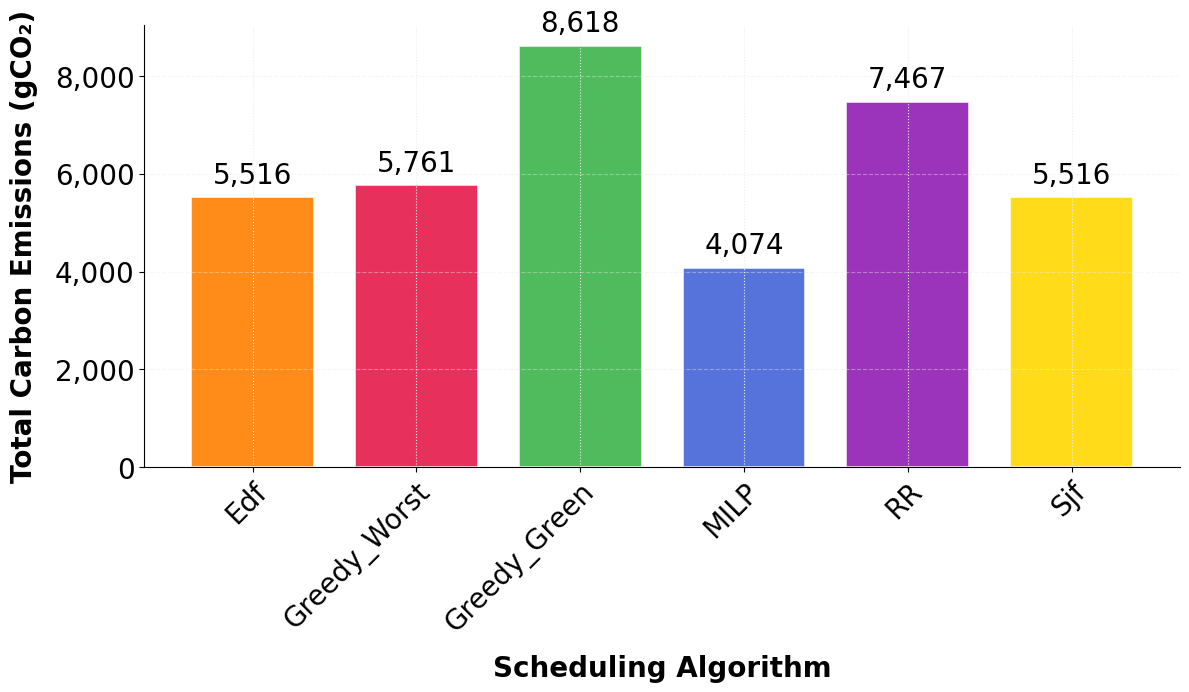

In [111]:
def total_emissions_schedule(schedule_df, schedule_name):
    """Calculate and print total carbon emissions for a schedule"""
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name:8} total emissions: {total:,.2f} gCO2")
    return total

def plot_algorithm_emissions_comparison():
    """
    Compare carbon emissions across scheduling algorithms with enhanced visualization

    Args:
        save_path: Path to save the output figure
    """
    # Calculate totals
    algorithm_names = []
    emission_totals = []

    for algo_name, df in schedules.items():
        if algo_name in colors:  # Only process if we have a color defined
            total = total_emissions_schedule(df, algo_name)
            algorithm_names.append(algo_name)
            emission_totals.append(total)

    # Create figure with professional styling
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Create bars with consistent ordering
    bars = ax.bar(algorithm_names, emission_totals,
                 color=[colors[algo] for algo in algorithm_names],
                 width=0.75, edgecolor='white', linewidth=1.2, alpha=0.9)

    # Customize axes and labels
    ax.set_xlabel("Scheduling Algorithm", fontsize=20, labelpad=12, fontweight='bold')
    ax.set_ylabel("Total Carbon Emissions (gCO₂)", fontsize=20, labelpad=12, fontweight='bold')
    # ax.set_title("Carbon Efficiency of Scheduling Algorithms",
    #             fontsize=14, pad=20, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=20)
    plt.yticks(fontsize=20)
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        offset = max(emission_totals) * 0.02  # Dynamic offset based on max value
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:,.0f}',
                ha='center', va='bottom',
                fontsize=20)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)

    # Clean up chart borders
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{graphs_output}algorithm_comparison.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show()

# Example usage
plot_algorithm_emissions_comparison()

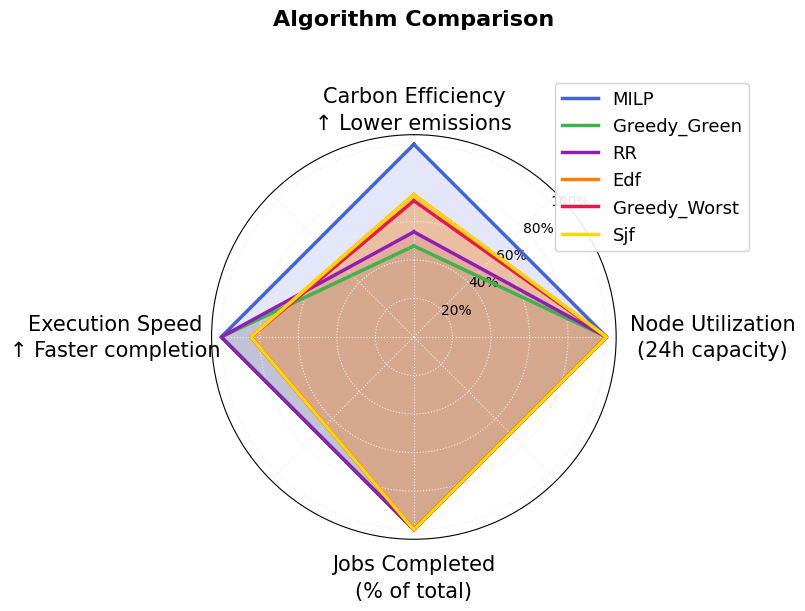

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def create_radar_chart(schedule_files, title="Algorithm Comparison"):
    # Load and process data
    metrics = {}
    total_jobs = len(pd.read_csv(next(iter(schedule_files.values())))['job_id'].unique())
    max_hours = 24  # Maximum utilization per node (24 hours)

    for algo, filepath in schedule_files.items():
        df = pd.read_csv(filepath)
        completed_jobs = df['job_id'].nunique()

        # Calculate metrics
        total_allocated_hours = df['allocated_time'].sum() / 3600
        utilization_pct = (total_allocated_hours / max_hours) * 100

        metrics[algo] = {
            '1_Carbon': 1/(df['carbon_emissions'].sum() + 1e-6),
            '2_Utilization': utilization_pct,
            '3_Completion': (completed_jobs / total_jobs) * 100,
            '4_Speed': 1/df['allocated_time'].mean()
        }

    # Normalize and cap metrics
    metrics_df = pd.DataFrame(metrics).T
    normalized_df = (metrics_df / metrics_df.max()).clip(upper=1.0)

    # Prepare radar coordinates
    categories = sorted(metrics_df.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Create figure with optimized layout
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'polar': True},
                         constrained_layout=True)

    # Configure polar plot
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.ylim(0, 1.05)  # Slight buffer above 100%

    # Custom label properties
    label_properties = {
        '1_Carbon': {
            'text': 'Carbon Efficiency\n↑ Lower emissions',
            'pad': 1.18,
            'ha': 'center',
            'rotation': 90  # Degrees
        },
        '2_Utilization': {
            'text': 'Node Utilization\n(24h capacity)',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 0
        },
        '3_Completion': {
            'text': 'Jobs Completed\n(% of total)',
            'pad': 1.25,
            'ha': 'center',
            'rotation': 270
        },
        '4_Speed': {
            'text': 'Execution Speed\n↑ Faster completion',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 180
        }
    }

    # Add metric labels with precise positioning
    for angle, category in zip(angles[:-1], categories):
        props = label_properties[category]
        ax.text(
            angle, props['pad'], props['text'],
            ha=props['ha'], va='center',
            fontsize=15,
            linespacing=1.4,
            rotation=angle*180/pi - 90 + props['rotation'],
            rotation_mode='anchor'
        )

    # Configure radial grid
    ax.set_rgrids(
        [0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["20%", "40%", "60%", "80%", "100%"],
        angle=45,
        fontsize=10,
        verticalalignment='center'
    )

    ax.set_xticklabels([])
    # Plot each algorithm's data

    for algo in normalized_df.index:
        values = normalized_df.loc[algo].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[algo], linewidth=2.5, label=algo)
        ax.fill(angles, values, color=colors[algo], alpha=0.15)

    # Add title and legend
    plt.title(title, y=1.25, fontsize=16, weight='bold')
    plt.legend(
        loc='upper right',
        bbox_to_anchor=(1.35, 1.15),
        framealpha=0.9,
        fontsize=13
    )

    # Save as high-quality PDF
    plt.savefig(
        f'{graphs_output}/comparison_algos_radar.pdf',
        format="pdf",
        dpi=800,
        bbox_inches='tight',
        transparent=True
    )
    plt.show()

# Example usage
schedule_files = {
    'MILP': f'{schedules_path}milp_green.csv',
    'Greedy_Green': f'{schedules_path}carbon_aware_min_case.csv',
    'RR': f'{schedules_path}round_robin_schedule.csv',
    'Edf': f'{schedules_path}edf_schedule.csv',
    'Greedy_Worst': f'{schedules_path}carbon_aware_max_case.csv',
    'Sjf': f'{schedules_path}sjf_schedule.csv'
}

create_radar_chart(schedule_files)

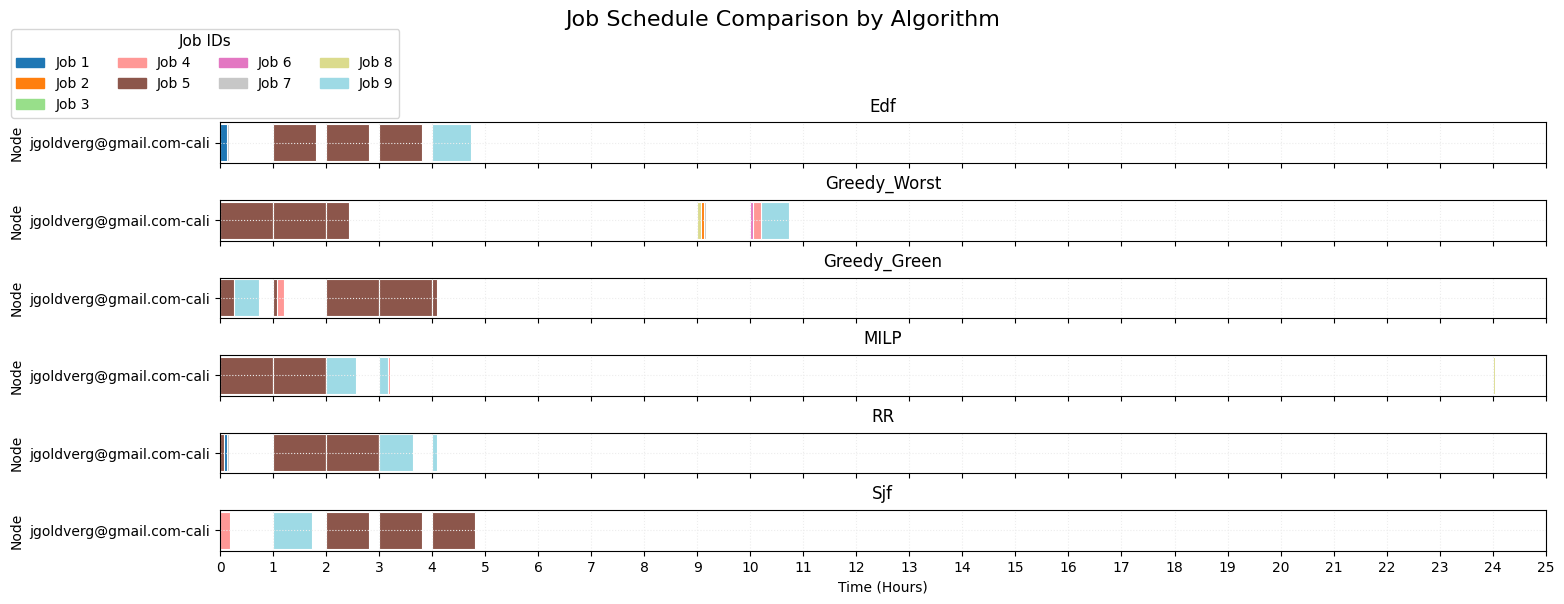

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def create_clean_gantt(schedules):
    """
    Create a clean Gantt chart comparison of scheduling algorithms using forecast_id (hours) on x-axis

    Args:
        schedules: Dictionary of {algorithm_name: schedule_df}
        graphs_output: Path to save output figures
    """
    # Combine all data to establish consistent colors
    all_data = pd.concat([df.assign(Algorithm=algo) for algo, df in schedules.items()])

    # Create universal job color mapping
    jobs = sorted(all_data['job_id'].unique())
    cmap = plt.get_cmap('tab20', len(jobs))
    job_colors = {job: cmap(i) for i, job in enumerate(jobs)}

    # Setup figure with clean style
    plt.style.use('default')  # Reset to default style
    plt.rcParams.update({
        'axes.grid': True,
        'grid.color': '#EDEDED',
        'grid.linestyle': ':',
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10
    })

    n_algorithms = len(schedules)
    fig, axes = plt.subplots(n_algorithms, 1, figsize=(16, 1.0 * n_algorithms), sharex=True)  # Reduced height and sharex
    fig.suptitle('Job Schedule Comparison by Algorithm', fontsize=16, y=1.02)

    # Get max forecast hour across all schedules
    max_hour = max(df['forecast_id'].max() for df in schedules.values()) + 1

    # Process each algorithm
    for i, (ax, (algo, df)) in enumerate(zip(axes, schedules.items())):
        # Plot each job
        for _, row in df.iterrows():
            duration_hours = row['allocated_time'] / 3600  # Convert seconds to hours

            ax.barh(
                y=row['node'],
                width=duration_hours,
                left=row['forecast_id'],
                height=0.5,  # Smaller bar height
                color=job_colors[row['job_id']],
                edgecolor='white',
                linewidth=0.8,
            )

        # Subplot formatting
        ax.set_title(algo, pad=8)  # Reduced padding
        ax.set_ylabel('Node')

        # Only show x-axis label on bottom plot
        if i == n_algorithms - 1:
            ax.set_xlabel('Time (Hours)')
        else:
            ax.set_xlabel('')

        # Set consistent x-axis
        ax.set_xlim(0, max_hour)
        ax.set_xticks(np.arange(0, max_hour + 1, 1))
        ax.set_xticklabels([f"{int(x)}" for x in np.arange(0, max_hour + 1, 1)])

    # Create unified legend
    legend_elements = [Patch(color=job_colors[job], label=f'Job {job}') for job in jobs]
    fig.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(0.265, 1.0),
        title='Job IDs',
        fontsize=10,
        title_fontsize=11,
        ncol=min(4, len(jobs)))

    plt.tight_layout(pad=2.0, h_pad=0.5)  # Reduced spacing between subplots
    plt.savefig(f'{graphs_output}/clean_gantt_comparison_algos.pdf',
               format="pdf",
               dpi=800,
               bbox_inches='tight')
    plt.show()

create_clean_gantt(schedules)

In [114]:
total_time = 3600 * 25
milp_df =  schedules['MILP']
allocated_time = milp_df['allocated_time'].sum()
print(allocated_time)
print(allocated_time/total_time)

algo_utilization = {}
for key, df in schedules.items():
    allocated_time = df['allocated_time'].sum()
    utilization = (allocated_time/ total_time) * 100
    algo_utilization[key] = utilization

print(algo_utilization)

14718.928394951561
0.16354364883279512
{'Edf': 16.354364891994148, 'Greedy_Worst': 16.354364891994148, 'Greedy_Green': 16.354364891994148, 'MILP': 16.354364883279512, 'RR': 16.354364891994148, 'Sjf': 16.35436489199415}
